# 8장  
앞에서 사용한 트랜스포머 모델들에서 정확도 만으로는 성능이 좋다는 것을 확신할수없다.  
모델이 너무 느리거나 크다면 성능이 최고여도 의미없다.  
그 대안은 빠르고 작은 모델을 훈련하는 것이다. 하지만 모델이 작아지면 종종 성능이 저하된다.  
이 장에서는 예측 속도를 높이고 트랜스포머 모델의 메모리 사용량을 줄이는 기술 4가지를 공부한다.  
1. 지식 정제(knowledge distillation)  
2. 양자화(quantization)
3. 가지치기(pruning)
4. ONNX(Open Neural Network Exchange)포맷과 ONNX 런타임을 사용한 그래프 최적화  

In [1]:
# 코랩이나 캐글을 사용한다면 이 셀의 주석을 제거하고 실행하세요.
!git clone https://github.com/rickiepark/nlp-with-transformers.git
%cd nlp-with-transformers
from install import *
install_requirements(chapter=8)

Cloning into 'nlp-with-transformers'...
remote: Enumerating objects: 653, done.
remote: Counting objects: 100% (84/84), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 653 (delta 47), reused 15 (delta 8), pack-reused 569
Receiving objects: 100% (653/653), 62.41 MiB | 9.07 MiB/s, done.
Resolving deltas: 100% (335/335), done.
/content/nlp-with-transformers
⏳ Installing base requirements ...
✅ Base requirements installed!
Using transformers v4.41.2
Using datasets v2.20.0
Using accelerate v0.32.1
Using optuna v3.6.1
Using onnxruntime v1.18.1
Using onnx v1.16.1


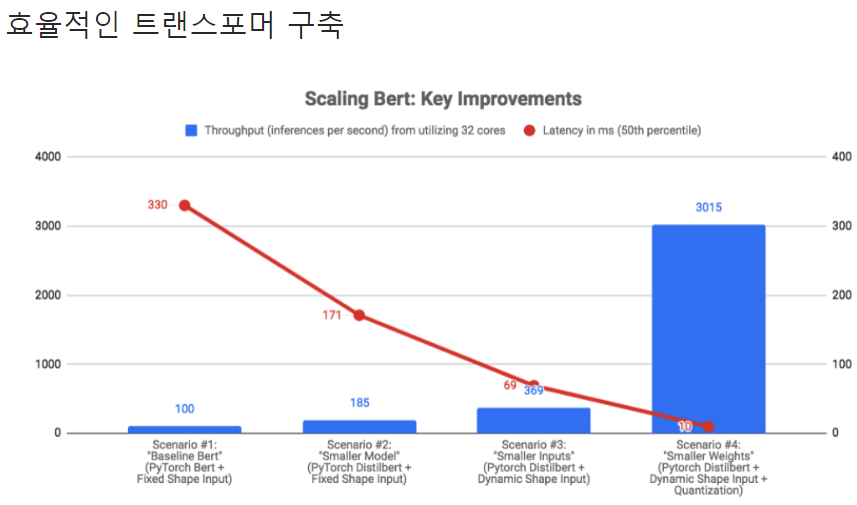

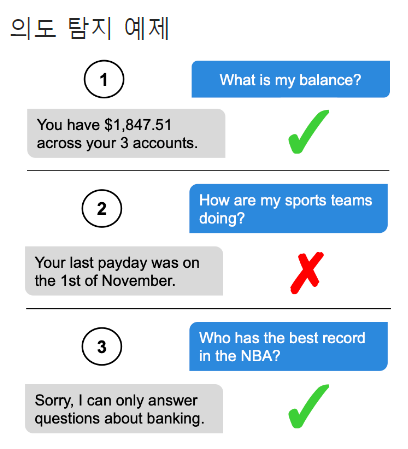

의도 탐지는 챗봇에서 중요한 구성요소이며 실시간 대화를 위해 레이턴시가 낮아야 한다.  
여기서는 CLINIC150이라는 데이터 셋을 사용한다. 그리고 이에 맞게 미세 튜닝한 BERT 모델을 사용  
이 데이터셋에는 150개의 의도와 은행, 여행등 10개의 분야로 분류된 쿼리 22500개가 존재.  
범위를 벗어난 쿼리도 1200개 존재 이건 OOS로 분류  

In [2]:
from transformers import pipeline

bert_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"
pipe = pipeline("text-classification", model=bert_ckpt)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/8.18k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [3]:
query = """Hey, I'd like to rent a vehicle from Nov 1st to Nov 15th in
Paris and I need a 15 passenger van"""
pipe(query)

[{'label': 'car_rental', 'score': 0.5490034222602844}]

# 벤치마크 클래스 만들기  

1. 모델성능:모델 성능은 특히 오류가 발생했을 때 손실 비용이 큰 상황이나,수백만 개의 샘플에서  
추론을 실행해야 하므로 모델 지표가 조금 향상되면 전체적으로 큰 이득을 얻을 수 있는 상황에서 중요하다.  
2. 레이턴시:레이턴시는 보통 대량의 트랙픽을 처리하는 실시간 환경에서 고려합니다.  

3. 메모리는 모바일과 에지 장치에서 특별히 중요한 역할을 수행한다. 이 환경에서 모델이  
강력한 클라우드 서버에 접속하지 않고 예측을 만들어야한다.  



In [4]:
class PerformanceBenchmark:
    def __init__(self, pipeline, dataset, optim_type="BERT baseline"):
        self.pipeline = pipeline
        self.dataset = dataset
        self.optim_type = optim_type

    def compute_accuracy(self):
        # 나중에 정의합니다
        pass

    def compute_size(self):
        # 나중에 정의합니다
        pass

    def time_pipeline(self):
        # 나중에 정의합니다
        pass

    def run_benchmark(self):
        metrics = {}
        metrics[self.optim_type] = self.compute_size()
        metrics[self.optim_type].update(self.time_pipeline())
        metrics[self.optim_type].update(self.compute_accuracy())
        return metrics

In [5]:
from datasets import load_dataset

clinc = load_dataset("clinc_oos", "plus")
'''
위에서 말한 데이터 셋 성능 확인하려고 미세 튜닝한 데이터 셋 가져옴
plus 는 범위 밖의 훈련 샘플이 담긴 서브셋을 의미
'''

Generating train split:   0%|          | 0/15250 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3100 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5500 [00:00<?, ? examples/s]

'\n위에서 말한 데이터 셋 성능 확인하려고 미세 튜닝한 데이터 셋 가져옴\nplus 는 범위 밖의 훈련 샘플이 담긴 서브셋을 의미\n'

In [6]:
clinc

DatasetDict({
    train: Dataset({
        features: ['text', 'intent'],
        num_rows: 15250
    })
    validation: Dataset({
        features: ['text', 'intent'],
        num_rows: 3100
    })
    test: Dataset({
        features: ['text', 'intent'],
        num_rows: 5500
    })
})

In [7]:
sample = clinc["test"][42]
sample

{'text': 'transfer $100 from my checking to saving account', 'intent': 133}

In [8]:
intents = clinc["test"].features["intent"]
intents.int2str(sample["intent"])

'transfer'

In [9]:
!pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.3 MB/s eta 0:00:00


In [10]:
import evaluate

accuracy_score = evaluate.load("accuracy")

In [11]:
def compute_accuracy(self):
    """PerformanceBenchmark.compute_accuracy() 메서드를 오버라이드합니다"""
    preds, labels = [], []
    for example in self.dataset:
        pred = self.pipeline(example["text"])[0]["label"]
        label = example["intent"]
        preds.append(intents.str2int(pred))
        labels.append(label)
    accuracy = accuracy_score.compute(predictions=preds, references=labels)
    print(f"테스트 세트 정확도 - {accuracy['accuracy']:.3f}")
    return accuracy
#정확도 계산하는 함수
PerformanceBenchmark.compute_accuracy = compute_accuracy

In [12]:
list(pipe.model.state_dict().items())[42]

('bert.encoder.layer.2.attention.self.value.bias',
 tensor([-2.7834e-02,  4.9434e-02,  8.3551e-02,  4.1092e-02,  6.0157e-01,
          1.1774e-01, -5.2112e-02, -6.5143e-02, -2.9358e-02, -4.2250e-02,
          7.9177e-02,  8.0409e-02,  2.9921e-03,  1.7816e-01, -5.0480e-02,
         -1.5634e-01, -2.1707e-02,  1.4381e-02,  2.5132e-02, -2.4110e-02,
         -1.9183e-01, -7.8657e-02,  5.0709e-02,  3.3632e-02, -3.1946e-02,
          1.1616e-01,  9.2720e-02, -1.1787e-01,  2.3233e-01, -1.2678e-02,
         -1.3138e-01, -4.0024e-02,  7.4823e-02, -5.4148e-02, -1.5184e-01,
         -7.4407e-02,  1.1559e-01,  8.2729e-02, -1.3787e-01,  8.3528e-02,
          1.2154e-01,  1.6880e-02, -5.6629e-02, -3.9295e-02,  5.3725e-02,
          6.8602e-02, -1.1294e-01,  4.4001e-02, -2.5884e-01,  1.6767e-01,
          1.8316e-01,  5.6272e-02, -3.6874e-02, -2.7938e-02, -9.3204e-02,
         -7.5239e-03,  4.1141e-02, -1.1542e-02, -9.9749e-02, -3.0910e-02,
          4.1398e-02, -4.4389e-02, -2.6279e-02,  7.2100e-02, 

In [13]:
import torch
from pathlib import Path

def compute_size(self):
    """PerformanceBenchmark.compute_size() 메서드를 오버라이드합니다"""
    state_dict = self.pipeline.model.state_dict()
    tmp_path = Path("model.pt")
    torch.save(state_dict, tmp_path)
    # 메가바이트 단위로 크기를 계산합니다
    size_mb = Path(tmp_path).stat().st_size / (1024 * 1024)
    # 임시 파일을 삭제합니다
    tmp_path.unlink()
    print(f"모델 크기 (MB) - {size_mb:.2f}")
    return {"size_mb": size_mb}
#모델의 크기를 계산하는 함수
PerformanceBenchmark.compute_size = compute_size

In [14]:
from time import perf_counter

for _ in range(3):
    start_time = perf_counter()
    _ = pipe(query)
    latency = perf_counter() - start_time
    print(f"레이턴시 (ms) - {1000 * latency:.3f}")

'''
레이턴시 계산하는 방법
결과 차이가 심하니까 평균내는게 일반적
'''

레이턴시 (ms) - 962.998
레이턴시 (ms) - 738.674
레이턴시 (ms) - 599.798


'\n레이턴시 계산하는 방법\n결과 차이가 심하니까 평균내는게 일반적\n'

In [15]:
import numpy as np

def time_pipeline(self, query="What is the pin number for my account?"):
    """PerformanceBenchmark.time_pipeline() 메서드를 오버라이드합니다d"""
    latencies = []
    # 워밍업
    for _ in range(10):
        _ = self.pipeline(query)
    # 실행 측정
    for _ in range(100):
        start_time = perf_counter()
        _ = self.pipeline(query)
        latency = perf_counter() - start_time
        latencies.append(latency)
    # 통계 계산
    time_avg_ms = 1000 * np.mean(latencies)
    time_std_ms = 1000 * np.std(latencies)
    print(f"평균 레이턴시 (ms) - {time_avg_ms:.2f} +\- {time_std_ms:.2f}")
    return {"time_avg_ms": time_avg_ms, "time_std_ms": time_std_ms}
#레이턴시 계산하는 함수
PerformanceBenchmark.time_pipeline = time_pipeline

'''
보통 레이턴시는 쿼리 길이에 따라 달라지므로 제품 환경에 마주하게 될 쿼리를 사용하는게 베스트'''

'\n보통 레이턴시는 쿼리 길이에 따라 달라지므로 제품 환경에 마주하게 될 쿼리를 사용하는게 베스트'

In [16]:
pb = PerformanceBenchmark(pipe, clinc["test"])
perf_metrics = pb.run_benchmark()

모델 크기 (MB) - 418.15
평균 레이턴시 (ms) - 468.80 +\- 157.23
테스트 세트 정확도 - 0.867


# 지식 정제로 모델 크기 줄이기  
내가 알고있는 teacher-student 방식으로 이해 함.  
느리고 크지만 성능 좋은 선생 모델을 가져와 작은 학생 모델을 만들어서 선생 모델을  
모방 학습 하도록 진행  
사전 훈련하는 언어 모델의 파라미터 개수가 꾸준히 증가하는 경향을 고려할 때,  
지식 정제는 대규모 모델을 압축해 실용적으로 만들 수 있다.  

##미세 튜닝에서의 지식 정제  
미세 튜닝 같은 지도 학습 작업에서는 티처의 소프트 확률로 정답 레이블을 보강해서   
스튜던트가 학습할 때 부가 정보를 제공하는 것이 주요 아이디어이다.  
BERT 기반 분류기가 여러 개의 의도에 높은 확률을 할당한다면, 이 의도들은 특성 공간 안에서  
서로 가까이 위치한다는 신호일 가능성이 있다. 이런 확률을 모방하도록 스튜던트를 훈련해서  
티처가 학습한 '검은 지식'을 정제한다.  
> 검은 지식이란 레이블만으로는 얻지 못하는 지식입니다.  

만약 입력 시퀀스 x를 티처에 넣으면 출력이 로짓 z(x)로 나온다. 이에 소프트 맥스를 적용하면 다음 식이 나온다.  
$\frac{exp(z_i(x))}{\Sigma_j exp(z_i(x))}$  
하지만 티처는 대부분 한 클래스에 높은 확률을 할당하고 나머지는 거의 0에 가깝게 만든다.  
이 경우 티처는 정답 레이블 외에 추가 정보를 많이 제공하지 않는다.  
따라서 소프트맥스 함수를 적용하기 전에 온도 파라미터 T로 로짓의 스케일을 조정해  
확률을 소프트하게 만들어야 한다.  
$p_i(x)=\frac{exp(z_i(x)/T)}{\Sigma_j exp(z_i(x)/T)}$


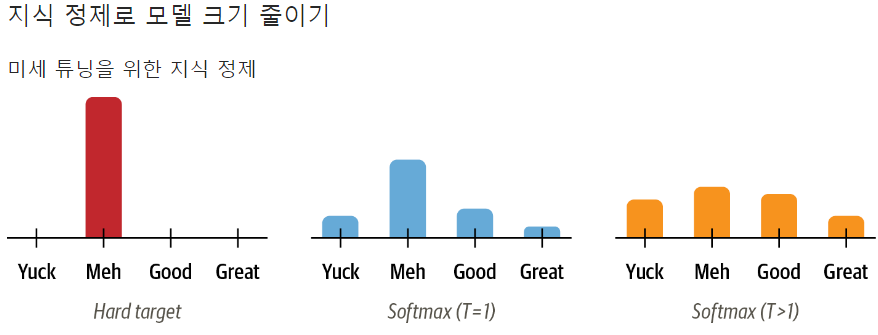

높은 T 값은 클래스에 대해 완만한 확률 분포를 만든다. 티처가 각 훈련 샘플로부터  
학습한 결정 경계에 대한 정보가 더 많이 드러난다.  
스튜던트도 자신의 소프트 확률 $q_i(x)$를 만들 수 있으므로 KL 발산을 사용해 두 분포의 차이를 측정한다.  
$D_{KL}(p,q)=Σ_i p_i(x) log\frac{p_i(x)}{q_i(x)} $  
KL 발산을 통해 티처의 확률분포를 스튜던트 분포에 근사해 손실되는 양을 계산한다.  
이를 통해 지식 정제 손실을 정의한다.  
$L_{KD}=T^2  D_{KL}$  
여기서 T는 위에서 T로 스케일 조정을 했으므로 그걸 고려한 정규화 인자이다.  
분류작업에서 스튜던트 손실은 정답에 대한 크로스 엔트로피 손실 $L_{CE}$로 정제 손실을 가중 평균 했다.  
$L_{student}=\alpha L_{CE}+(1-\alpha)L_{KD}$  
추론 시에는 (test 할때는) T를 1로 설정해서 원래 소프트 맥스 함수를 사용한다.

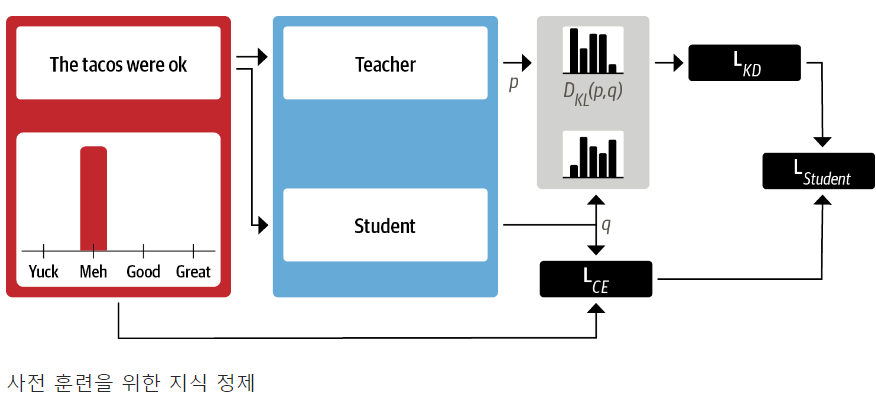

#사전 훈련에서의지식 정제  
사전 훈련하는 동안 후속 작업에서 미세 튜닝이 가능한 범용 스튜던트를 만들기 위해   
지식 정제를 사용할 수도 있다.  
이 경우 티처는 마스크드 언어 모델의 지식을 스튜던트에 전달하는 BERT 같은 사전 훈련된 언어 모델이다.  
DistilBERT는 마스크드 언어 모델링 손실$L_{mlm}$은 지식 정제 항과 티처와 스튜던트 간의 은닉 상채 벡터의  
방향을 정렬하기 위해 코사인 임베딩 손실$L_{cos}=1-cos(h_s,h_t)$로 보강된다.  
$L_{DistilBERT}=\alpha L_{mlm}+\beta L_{KD}+\gamma L_{cos}$  
우리는 미세튜닝된 BERT 기반 모델을 사용하므로 지식 정제를 사용해 더 작고 빠른 모델을 미세 튜닝하는 방법을 공부한다.

In [17]:
from transformers import TrainingArguments

class DistillationTrainingArguments(TrainingArguments):
    def __init__(self, *args, alpha=0.5, temperature=2.0, **kwargs):
        super().__init__(*args, **kwargs)
        self.alpha = alpha
        self.temperature = temperature

super().__init__(*args, **kwargs)는 부모 클래스인 TrainingArguments의 생성자를
호출하면서,  
전달받은 위치 인수(*args)와 키워드 인수(**kwargs)를 그대로 전달하여 초기화하겠다는 의미입니다.

In [18]:
import torch.nn as nn
import torch.nn.functional as F
from transformers import Trainer

class DistillationTrainer(Trainer):
    def __init__(self, *args, teacher_model=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.teacher_model = teacher_model

    def compute_loss(self, model, inputs, return_outputs=False):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        inputs = inputs.to(device)
        outputs_stu = model(**inputs)
        # 스튜던트의 크로스 엔트로피 손실과 로짓을 추출합니다
        loss_ce = outputs_stu.loss
        logits_stu = outputs_stu.logits
        # 티처의 로짓을 추출합니다
        with torch.no_grad():
            outputs_tea = self.teacher_model(**inputs)
            logits_tea = outputs_tea.logits
        # 확률을 부드럽게하고 정제 손실을 계산합니다
        loss_fct = nn.KLDivLoss(reduction="batchmean")
        loss_kd = self.args.temperature ** 2 * loss_fct(
            F.log_softmax(logits_stu / self.args.temperature, dim=-1),
            F.softmax(logits_tea / self.args.temperature, dim=-1))# 왜 이런 입력인지 모르겠지만 이렇게 사용함 (log_student,teacher) teacher는 알아서 log 취해주는거 같음
        # 가중 평균된 스튜던트 손실을 반환합니다
        loss = self.args.alpha * loss_ce + (1. - self.args.alpha) * loss_kd
        return (loss, outputs_stu) if return_outputs else loss

위에서 티처의 모델을 선택해서 값을 가져오는 것은 끝냈다. 그럼 이제 학생꺼 모델을 어떤걸 쓸지 생각해야됨  
이 방식의 애초 목적은 작은 모델로 좋은 성능을 얻기 위해 하는 것임  
논문에 의하면 티처와 스튜던트가 동일한 종류의 모델 일 때 지식 정제가 잘 작동함  
모델 종류가 다르면 출력 임베딩 공간이 달라서 모방하는데 방해가 됨  
여기서는 티처가 BERT니까 DistilBERT가 후보로 올라옴  
파라미터 40% 적지만 성능은 큰 차이 안남

In [19]:
from transformers import AutoTokenizer

student_ckpt = "distilbert-base-uncased"
student_tokenizer = AutoTokenizer.from_pretrained(student_ckpt)

def tokenize_text(batch):
    return student_tokenizer(batch["text"], truncation=True)

clinc_enc = clinc.map(tokenize_text, batched=True, remove_columns=["text"])
clinc_enc = clinc_enc.rename_column("intent", "labels")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/15250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3100 [00:00<?, ? examples/s]

Map:   0%|          | 0/5500 [00:00<?, ? examples/s]

In [20]:
from huggingface_hub import notebook_login

notebook_login()

In [21]:
def compute_metrics(pred):
    predictions, labels = pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy_score.compute(predictions=predictions, references=labels)

In [22]:
batch_size = 48

finetuned_ckpt = "distilbert-base-uncased-finetuned-clinc"
student_training_args = DistillationTrainingArguments(
    output_dir=finetuned_ckpt, evaluation_strategy = "epoch",
    num_train_epochs=5, learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size, alpha=1, weight_decay=0.01,
    push_to_hub=True)
#여기서는 alpha를 1로해서 티처의 영향이 없을 때 성능을 체크

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [23]:
student_training_args.logging_steps = len(clinc_enc['train']) // batch_size
student_training_args.disable_tqdm = False
student_training_args.save_steps = 1e9
# 트랜스포머 4.23.0 버전부터 로깅 수준을 문자열로 지정해야 합니다.
# student_training_args.log_level = 40
student_training_args.log_level = 'error'

In [24]:
%env TOKENIZERS_PARALLELISM=false

env: TOKENIZERS_PARALLELISM=false


In [25]:
id2label = pipe.model.config.id2label
label2id = pipe.model.config.label2id
print(id2label)
print('*'*20)
print(label2id)

{0: 'restaurant_reviews', 1: 'nutrition_info', 2: 'account_blocked', 3:
'oil_change_how', 4: 'time', 5: 'weather', 6: 'redeem_rewards', 7:
'interest_rate', 8: 'gas_type', 9: 'accept_reservations', 10: 'smart_home', 11:
'user_name', 12: 'report_lost_card', 13: 'repeat', 14: 'whisper_mode', 15:
'what_are_your_hobbies', 16: 'order', 17: 'jump_start', 18: 'schedule_meeting',
19: 'meeting_schedule', 20: 'freeze_account', 21: 'what_song', 22:
'meaning_of_life', 23: 'restaurant_reservation', 24: 'traffic', 25: 'make_call',
26: 'text', 27: 'bill_balance', 28: 'improve_credit_score', 29:
'change_language', 30: 'no', 31: 'measurement_conversion', 32: 'timer', 33:
'flip_coin', 34: 'do_you_have_pets', 35: 'balance', 36: 'tell_joke', 37:
'last_maintenance', 38: 'exchange_rate', 39: 'uber', 40: 'car_rental', 41:
'credit_limit', 42: 'oos', 43: 'shopping_list', 44: 'expiration_date', 45:
'routing', 46: 'meal_suggestion', 47: 'tire_change', 48: 'todo_list', 49:
'card_declined', 50: 'rewards_balance', 5

In [26]:
from transformers import AutoConfig

num_labels = intents.num_classes
student_config = (AutoConfig
                  .from_pretrained(student_ckpt, num_labels=num_labels,
                                   id2label=id2label, label2id=label2id))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [27]:
import torch
from transformers import AutoModelForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def student_init():
    return (AutoModelForSequenceClassification
            .from_pretrained(student_ckpt, config=student_config).to(device))

In [28]:
teacher_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"
teacher_model = (AutoModelForSequenceClassification
                 .from_pretrained(teacher_ckpt, num_labels=num_labels)
                 .to(device))

In [30]:
distilbert_trainer = DistillationTrainer(model_init=student_init,
    teacher_model=teacher_model, args=student_training_args,
    train_dataset=clinc_enc['train'], eval_dataset=clinc_enc['validation'],
    compute_metrics=compute_metrics, tokenizer=student_tokenizer)

distilbert_trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,4.304700,3.293084,0.725484
2,2.644800,1.884935,0.852581
3,1.565200,1.170155,0.889677
4,1.028800,0.871707,0.914516
5,0.814500,0.787232,0.920645


TrainOutput(global_step=1590, training_loss=2.0674820442619564, metrics={'train_runtime': 290.0443, 'train_samples_per_second': 262.891, 'train_steps_per_second': 5.482, 'total_flos': 414689637990180.0, 'train_loss': 2.0674820442619564, 'epoch': 5.0})

In [31]:
distilbert_trainer.push_to_hub("Training completed!")

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

events.out.tfevents.1720161498.144cca224a56.209.0:   0%|          | 0.00/15.4k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.18k [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/kwkwkwkwpark/distilbert-base-uncased-finetuned-clinc/commit/052e8c7ef52dd7c6467f47b3c8bf646332d0296e', commit_message='Training completed!', commit_description='', oid='052e8c7ef52dd7c6467f47b3c8bf646332d0296e', pr_url=None, pr_revision=None, pr_num=None)

In [32]:
finetuned_ckpt = "kwkwkwkwpark/distilbert-base-uncased-finetuned-clinc"
pipe = pipeline("text-classification", model=finetuned_ckpt)

config.json:   0%|          | 0.00/8.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [33]:
optim_type = "DistilBERT"
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

모델 크기 (MB) - 255.88
평균 레이턴시 (ms) - 40.16 +\- 4.06
테스트 세트 정확도 - 0.851


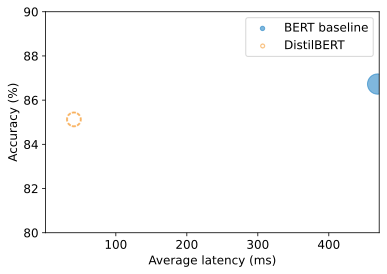

In [34]:
import pandas as pd

def plot_metrics(perf_metrics, current_optim_type):
    df = pd.DataFrame.from_dict(perf_metrics, orient='index')

    for idx in df.index:
        df_opt = df.loc[idx]
        # 현재 최적화 방법을 점선으로 그립니다
        if idx == current_optim_type:
            plt.scatter(df_opt["time_avg_ms"], df_opt["accuracy"] * 100,
                        alpha=0.5, s=df_opt["size_mb"], label=idx,
                        marker='$\u25CC$')
        else:
            plt.scatter(df_opt["time_avg_ms"], df_opt["accuracy"] * 100,
                        s=df_opt["size_mb"], label=idx, alpha=0.5)

    legend = plt.legend(bbox_to_anchor=(1,1))
    for handle in legend.legend_handles:
        handle.set_sizes([20])

    plt.ylim(80,90)
    # 가장 느린 모델을 사용해 x 축 범위를 정합니다
    xlim = int(perf_metrics["BERT baseline"]["time_avg_ms"] + 3)
    plt.xlim(1, xlim)
    plt.ylabel("Accuracy (%)")
    plt.xlabel("Average latency (ms)")
    plt.show()

plot_metrics(perf_metrics, optim_type)

그래프를 보면 정확도 거의 1%를 손해보고 레이턴시가 엄청나게 줄어들음
엄청난 이득을 봐버림  
여기서 성능을 더 개선하기 위해서 최적의 $\alpha$와 T를 찾아야 함

#최적의 파라미터 찾기 옵투나 라이브러리 이용  
가장 중요한 과정 중 하나이다. 이거 하느라 강화 학습때 엄청 고생했었다.  
근데 시간은 오래걸릴거 같음 어쩔수 없지...

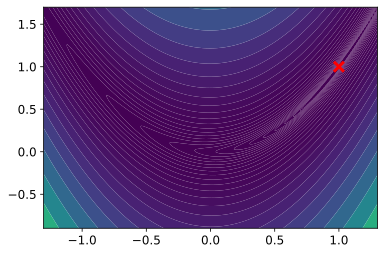

In [35]:
# 두 변수를 가진 로젠브록 함수 그래프
import matplotlib.pyplot as plt
import numpy as np

def f(x, y):
    return (1-x)**2+100*(y-x**2)**2

X, Y = np.meshgrid(np.linspace(-2, 2, 250), np.linspace(-1, 3, 250))
Z = f(X,Y)
_, ax = plt.subplots()
ax.plot([1], [1], 'x', mew=3, markersize=10, color="red")
ax.contourf(X, Y, Z, np.logspace(-1, 3, 30), cmap='viridis', extend="both")
ax.set_xlim(-1.3, 1.3)
ax.set_ylim(-0.9, 1.7)
plt.show()

In [36]:
def objective(trial):
    x = trial.suggest_float("x", -2, 2)
    y = trial.suggest_float("y", -2, 2)
    return (1 - x) ** 2 + 100 * (y - x ** 2) ** 2

In [37]:
import optuna

study = optuna.create_study()
study.optimize(objective, n_trials=1000)

[I 2024-07-05 06:47:29,848] A new study created in memory with name: no-name-cdc0b442-2fb2-4a2d-bb10-50e13c4ff7b1
[I 2024-07-05 06:47:29,851] Trial 0 finished with value: 137.63145341626034 and parameters: {'x': 0.4644108914037566, 'y': -0.9562636390320449}. Best is trial 0 with value: 137.63145341626034.
[I 2024-07-05 06:47:29,854] Trial 1 finished with value: 17.999076207503357 and parameters: {'x': 0.4551207557113335, 'y': -0.21360471811139403}. Best is trial 1 with value: 17.999076207503357.
[I 2024-07-05 06:47:29,856] Trial 2 finished with value: 1256.5303999868966 and parameters: {'x': 1.7869532268970798, 'y': -0.3506817755634417}. Best is trial 1 with value: 17.999076207503357.
[I 2024-07-05 06:47:29,858] Trial 3 finished with value: 95.9720163597857 and parameters: {'x': -0.23271302475494382, 'y': 1.0260217776836935}. Best is trial 1 with value: 17.999076207503357.
[I 2024-07-05 06:47:29,860] Trial 4 finished with value: 1215.613145493837 and parameters: {'x': 1.653707751984237

In [38]:
study.best_params

{'x': 0.9835185077770215, 'y': 0.9672489610853879}

In [39]:
def hp_space(trial):
    return {"num_train_epochs": trial.suggest_int("num_train_epochs", 5, 10),
        "alpha": trial.suggest_float("alpha", 0, 1),
        "temperature": trial.suggest_int("temperature", 2, 20)}

In [40]:
best_run = distilbert_trainer.hyperparameter_search(
    n_trials=20, direction="maximize", hp_space=hp_space)

[I 2024-07-05 06:47:49,309] A new study created in memory with name: no-name-431b10c6-ff86-4edd-a28c-4db00ea4a8b0


Epoch,Training Loss,Validation Loss,Accuracy
1,0.424900,0.212167,0.600000
2,0.175700,0.100119,0.826774
3,0.107600,0.065419,0.882903
4,0.079900,0.049856,0.900323
5,0.065400,0.040586,0.910645
6,0.056800,0.035505,0.912903
7,0.051700,0.032783,0.921935
8,0.048700,0.030923,0.925161
9,0.047200,0.030380,0.927097


[I 2024-07-05 06:56:44,220] Trial 0 finished with value: 0.9270967741935484 and parameters: {'num_train_epochs': 9, 'alpha': 0.6805021394428374, 'temperature': 7}. Best is trial 0 with value: 0.9270967741935484.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.459900,0.229984,0.610968
2,0.188500,0.104705,0.838065
3,0.112300,0.066398,0.890000
4,0.082000,0.049734,0.902903
5,0.066500,0.040191,0.910645
6,0.057500,0.035133,0.919677
7,0.052300,0.032395,0.925806
8,0.049200,0.030574,0.927742
9,0.047600,0.030028,0.928710


[I 2024-07-05 07:05:44,917] Trial 1 finished with value: 0.9287096774193548 and parameters: {'num_train_epochs': 9, 'alpha': 0.09072563446073223, 'temperature': 5}. Best is trial 1 with value: 0.9287096774193548.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.389600,0.196676,0.577742
2,0.165200,0.098173,0.813871
3,0.105700,0.067648,0.871290
4,0.081700,0.053975,0.893548
5,0.069200,0.046015,0.900968
6,0.062300,0.041977,0.903548
7,0.059000,0.040764,0.905161


[I 2024-07-05 07:12:49,021] Trial 2 finished with value: 0.9051612903225806 and parameters: {'num_train_epochs': 7, 'alpha': 0.2638742999466196, 'temperature': 15}. Best is trial 1 with value: 0.9287096774193548.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.426600,0.215857,0.593548
2,0.179800,0.104460,0.821613
3,0.112300,0.069975,0.876452
4,0.085400,0.054847,0.896129
5,0.071700,0.046198,0.903226
6,0.064100,0.041918,0.907097
7,0.060700,0.040641,0.908387


[I 2024-07-05 07:19:40,375] Trial 3 finished with value: 0.9083870967741936 and parameters: {'num_train_epochs': 7, 'alpha': 0.4138140724748254, 'temperature': 7}. Best is trial 1 with value: 0.9287096774193548.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.815900,0.429481,0.669032
2,0.336500,0.169010,0.822903
3,0.174900,0.096362,0.872903
4,0.122200,0.073526,0.897742
5,0.104200,0.067392,0.902903


[I 2024-07-05 07:24:33,966] Trial 4 finished with value: 0.9029032258064517 and parameters: {'num_train_epochs': 5, 'alpha': 0.4526453598493323, 'temperature': 2}. Best is trial 1 with value: 0.9287096774193548.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.424400,0.210945,0.604839
2,0.174400,0.098733,0.829677
3,0.106000,0.063983,0.886774
4,0.078200,0.048364,0.900645
5,0.063500,0.039009,0.911290
6,0.054700,0.033849,0.916452
7,0.049400,0.031055,0.925484
8,0.046100,0.028743,0.929355
9,0.044000,0.027672,0.930968
10,0.042800,0.027330,0.931290


[I 2024-07-05 07:34:27,130] Trial 5 finished with value: 0.9312903225806451 and parameters: {'num_train_epochs': 10, 'alpha': 0.4017804276702659, 'temperature': 7}. Best is trial 5 with value: 0.9312903225806451.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.384000,0.192508,0.575806


[I 2024-07-05 07:35:26,281] Trial 6 pruned. 


Epoch,Training Loss,Validation Loss,Accuracy
1,0.391900,0.194604,0.587742


[I 2024-07-05 07:36:25,315] Trial 7 pruned. 


Epoch,Training Loss,Validation Loss,Accuracy
1,0.502300,0.261117,0.608387
2,0.216300,0.125131,0.826129
3,0.134600,0.084435,0.871935


[I 2024-07-05 07:39:22,749] Trial 8 pruned. 


Epoch,Training Loss,Validation Loss,Accuracy
1,0.460700,0.231653,0.606452
2,0.190300,0.106681,0.836129
3,0.114500,0.068474,0.886774
4,0.084500,0.051884,0.900968
5,0.069200,0.042475,0.909355
6,0.060500,0.037554,0.914839
7,0.055800,0.035136,0.920968


[I 2024-07-05 07:46:17,828] Trial 9 pruned. 


Epoch,Training Loss,Validation Loss,Accuracy
1,0.402500,0.199971,0.593871


[I 2024-07-05 07:47:17,952] Trial 10 pruned. 


Epoch,Training Loss,Validation Loss,Accuracy
1,0.408400,0.203954,0.591935


[I 2024-07-05 07:48:18,100] Trial 11 pruned. 


Epoch,Training Loss,Validation Loss,Accuracy
1,0.574400,0.287355,0.650968
2,0.227300,0.116066,0.842903
3,0.123500,0.067585,0.894839
4,0.085700,0.048856,0.910000
5,0.068200,0.039529,0.918065
6,0.058600,0.034940,0.926129
7,0.053300,0.032280,0.929677
8,0.050200,0.030674,0.929677
9,0.048600,0.030132,0.930645


[I 2024-07-05 07:57:17,845] Trial 12 finished with value: 0.9306451612903226 and parameters: {'num_train_epochs': 9, 'alpha': 0.20486853057509985, 'temperature': 3}. Best is trial 5 with value: 0.9312903225806451.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.805300,0.403601,0.677097
2,0.302000,0.134830,0.845806
3,0.138600,0.070057,0.897742
4,0.088800,0.049841,0.920645
5,0.069200,0.041518,0.926129
6,0.059200,0.037120,0.929355
7,0.053600,0.034385,0.934839
8,0.050200,0.032656,0.931935
9,0.048000,0.031405,0.933548
10,0.046800,0.031210,0.934839


[I 2024-07-05 08:07:09,165] Trial 13 finished with value: 0.9348387096774193 and parameters: {'num_train_epochs': 10, 'alpha': 0.24871950115328129, 'temperature': 2}. Best is trial 13 with value: 0.9348387096774193.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.424400,0.210945,0.604839


[I 2024-07-05 08:08:10,517] Trial 14 pruned. 


Epoch,Training Loss,Validation Loss,Accuracy
1,0.812500,0.420595,0.672581
2,0.324400,0.156203,0.832258
3,0.160800,0.085245,0.881613


[I 2024-07-05 08:11:08,758] Trial 15 pruned. 


Epoch,Training Loss,Validation Loss,Accuracy
1,0.394800,0.195992,0.586452


[I 2024-07-05 08:12:09,268] Trial 16 pruned. 


Epoch,Training Loss,Validation Loss,Accuracy
1,0.416100,0.208896,0.592258


[I 2024-07-05 08:13:10,738] Trial 17 pruned. 


Epoch,Training Loss,Validation Loss,Accuracy
1,0.459400,0.228578,0.612903
2,0.186900,0.103084,0.840645
3,0.110500,0.064821,0.890968
4,0.080100,0.048164,0.903226
5,0.064500,0.038591,0.914516
6,0.055300,0.033496,0.922258
7,0.049900,0.030706,0.927742
8,0.046500,0.028482,0.930000
9,0.044400,0.027419,0.932581
10,0.043200,0.027097,0.931935


[I 2024-07-05 08:23:01,399] Trial 18 pruned. 


Epoch,Training Loss,Validation Loss,Accuracy
1,0.388000,0.193453,0.581290


[I 2024-07-05 08:24:00,558] Trial 19 pruned. 


In [41]:
print(best_run)

BestRun(run_id='13', objective=0.9348387096774193,
hyperparameters={'num_train_epochs': 10, 'alpha': 0.24871950115328129,
'temperature': 2}, run_summary=None)


In [42]:
for k,v in best_run.hyperparameters.items():
    setattr(student_training_args, k, v) #위에 나온 값으로 파라미터 수정 해줌 이렇게 안하고 일일히 해도 상관없을듯
    #setattr(class 이름, self 변수 이름 str로 줘야 할듯, 값)
    #값이 없다?? 그대로 만들어줌
# 정제된 모델을 저장할 새로운 저장소를 정의합니다
distilled_ckpt = "distilbert-base-uncased-distilled-clinc"
student_training_args.output_dir = distilled_ckpt

# 최적의 매개변수로 새로운 Trainer를 만듭니다
distil_trainer = DistillationTrainer(model_init=student_init,
    teacher_model=teacher_model, args=student_training_args,
    train_dataset=clinc_enc['train'], eval_dataset=clinc_enc['validation'],
    compute_metrics=compute_metrics, tokenizer=student_tokenizer)

distil_trainer.train();

Epoch,Training Loss,Validation Loss,Accuracy
1,1.674600,1.115054,0.728387
2,0.859500,0.538989,0.870645
3,0.449300,0.317189,0.918387
4,0.284700,0.244170,0.935484
5,0.223100,0.220022,0.937742
6,0.197500,0.209847,0.941935
7,0.184800,0.203494,0.940645
8,0.177500,0.199858,0.944516
9,0.173200,0.197160,0.943548
10,0.171000,0.196926,0.944516


In [43]:
distil_trainer.push_to_hub("Training complete")

training_args.bin:   0%|          | 0.00/5.24k [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/kwkwkwkwpark/distilbert-base-uncased-distilled-clinc/commit/185fd0c3fe1548ef265585e45b6840cbd66bc836', commit_message='Training complete', commit_description='', oid='185fd0c3fe1548ef265585e45b6840cbd66bc836', pr_url=None, pr_revision=None, pr_num=None)

In [44]:
# `haesun`를 자신의 허브 사용자 이름으로 바꾸세요.
distilled_ckpt = "kwkwkwkwpark/distilbert-base-uncased-distilled-clinc"
pipe = pipeline("text-classification", model=distilled_ckpt)
optim_type = "Distillation"
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

config.json:   0%|          | 0.00/8.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

모델 크기 (MB) - 255.88
평균 레이턴시 (ms) - 37.85 +\- 2.58
테스트 세트 정확도 - 0.875


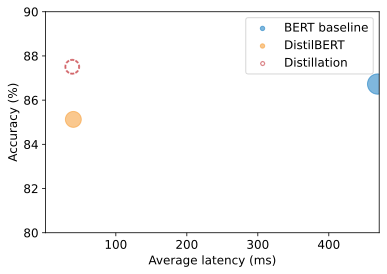

In [45]:
plot_metrics(perf_metrics, optim_type)

# 양자화  
계산량을 줄이는 대신, 가중치와 활성화 출력을 32비트 부동 소수점이 아닌 8비트 정수같이  
정밀도가 낮은 데이터 타입으로 표현해 계산을 더 효율적으로 수행한다.  
비트 수를 줄이면 모델에 필요한 메모리 양이 줄고 행렬 곱셈 같은 연산이  
정수 계산으로 훨씬 빠르게 수행된다. 근데 성능에는 영향이 거의 없다.  
***

양자화의 기본 아이디어는 부동 소수점 숫자f를 이산화 할 수 있다는 것이다.  
원래 범위 [$f_{max},f_{min}$]에서 고정 소수점 숫자 q로 표현된 작은 범위 [$q_{max},q_{min}$]으로 매핑하고  
모든 값을 이 사이에 선형적으로 분포 시킨다. 수식은 다음과 같다.  
$f=(\frac{f_{max}-f_{min}}{q_{max}-q_{min}})(q-Z)=S(q-Z)$  
여기서 스케일 인자 S는 양의 부동 소수점 숫자이다.  
상수 Z는 q와 타입이 동일하며 부동 소수점 값 f=0을 양자화한 값에  
해당하기 때문에 영점이라 부른다.  
고정 소수점 숫자를 역양자화해 부동 소수점 숫자로 되돌려야 하므로   
이 매핑은 아핀 변환입니다.(대충 y=Ax+b같은 꼴)

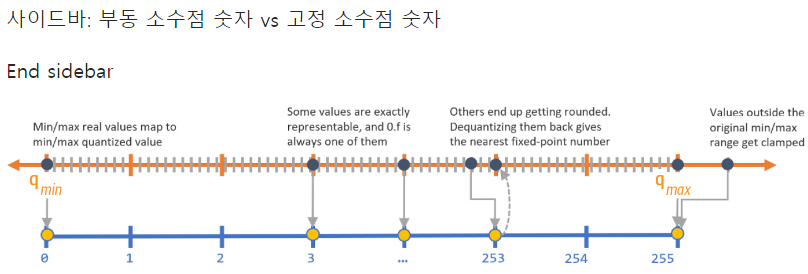

트랜스포머가 양자화의 주요 후보인 이유는 가중치와 활성화 값 범위가 비교적 좁기 때문이다.  
FP32 숫자의 전체 범위를 INT8로 표현되는 256개 숫자로 압축할 필요가 없다는 의미이다.

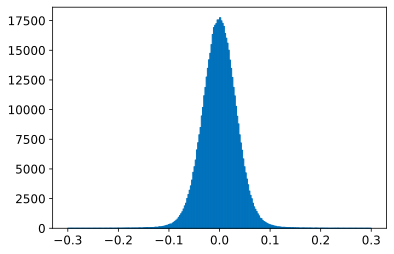

In [46]:
import matplotlib.pyplot as plt

state_dict = pipe.model.state_dict()
weights = state_dict["distilbert.transformer.layer.0.attention.out_lin.weight"]
plt.hist(weights.flatten().numpy(), bins=250, range=(-0.3,0.3), edgecolor="C0")
plt.show()

정말 대부분의 가중치 값이 [-0.1,0.1]에 분포 되어있다. 이 텐서를 부호가 있는 8비트 정수로 양자화 하자.   
이 경우 가능한 정수 범위는 [$q_{max},q_{min}$]=[-128,127]이다.

In [47]:
zero_point = 0
scale = (weights.max() - weights.min()) / (127 - (-128))

In [48]:
(weights / scale + zero_point).clamp(-128, 127).round().char()

tensor([[ -5,  -8,   0,  ...,  -6,  -4,   8],
        [  9,   3,   1,  ...,  -4,   7,   0],
        [ -8,  -5,   5,  ...,   1,   5,  -4],
        ...,
        [  6,   0,  13,  ...,   0,   6,  -1],
        [  0,  -2, -12,  ...,  12,  -7, -13],
        [-13,  -1,  -9,  ...,   8,   2,  -1]], dtype=torch.int8)

In [49]:
from torch import quantize_per_tensor

dtype = torch.qint8
quantized_weights = quantize_per_tensor(weights, scale, zero_point, dtype)
quantized_weights.int_repr()

tensor([[ -5,  -8,   0,  ...,  -6,  -4,   8],
        [  9,   3,   1,  ...,  -4,   7,   0],
        [ -8,  -5,   5,  ...,   1,   5,  -4],
        ...,
        [  6,   0,  13,  ...,   0,   6,  -1],
        [  0,  -2, -12,  ...,  12,  -7, -13],
        [-13,  -1,  -9,  ...,   8,   2,  -1]], dtype=torch.int8)

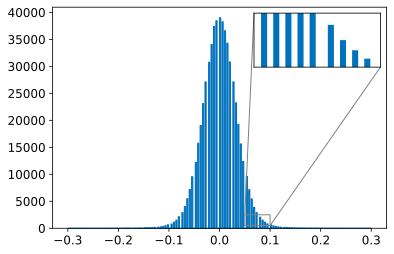

In [50]:
# 트랜스포머 가중치에서 양자화 효과
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes,mark_inset

# 히스토그램 그리기
fig, ax = plt.subplots()
ax.hist(quantized_weights.dequantize().flatten().numpy(),
         bins=250, range=(-0.3,0.3), edgecolor="C0");
# 확대 그림 만들기
axins = zoomed_inset_axes(ax, 5, loc='upper right')
axins.hist(quantized_weights.dequantize().flatten().numpy(),
         bins=250, range=(-0.3,0.3));
x1, x2, y1, y2 = 0.05, 0.1, 500, 2500
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.axes.xaxis.set_visible(False)
axins.axes.yaxis.set_visible(False)
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")
plt.show()

일부는 정확하게 매핑되고 중간중간 빈곳은 반올림해서 만들어진 부분임  
명확하게 이산화가 잘 된 모습을 보여줌  

In [51]:
%%timeit
weights @ weights

18.3 ms ± 1.03 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [52]:
from torch.nn.quantized import QFunctional

q_fn = QFunctional()#양자화된 텐서의 경우 torch.qint8 데이터 탑으로 연산을 수행하는 이 클래스가 필요함
#기초 사칙 연산 같은거 지원

In [53]:
%%timeit
q_fn.mul(quantized_weights, quantized_weights)

The slowest run took 6.10 times longer than the fastest. This could mean that an intermediate result is being cached.
881 µs ± 710 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


두개의 결과를 비교하면 양자화 된 계산이 100배이상 빠른 모습을 보여줌  
이는 전용 백엔드를 사용하면 차이가 훨씬 커짐

#양자화 주의할 점  
모든 연산에서 정밀도를 바꾸면 모델의 계산 그래프 각 지점에서 작은 변동이 생기고  
이는 모델 성능에 나쁜 영향을 미친다.  
모델을 양자화 하는 여러 가지 방법은 각기 장단점이 있는데 크게 3가지 방법이 있다.  
***
1. 동적 양자화  
훈련 도중에 아무것도 바뀌지 않고 추론 과정에만 적용한다. 다른 양자화 방법과  
마찬가지로 모델 가중치가 추론 전에 int8로 변환된다.  
가중치 외에 모델의 호라성화도 양자화되는데, 이는 즉석에서 일어나기 때문에 동적인 방식이다.  
모든 행렬 곱셈이 고도로 최적화된 INT8 함수로 계산된다는 것을 의미한다.  
모델의 가중치와 활성화 값을 추론 시점에서 실시간으로 양자화하는 기술입니다.   
이는 주로 추론 과정에서만 양자화를 적용하는 방법으로, 정적 양자화와 달리 훈련된 모델을  
그대로 유지하면서 실행 시에만 양자화를 적용합니다.  
 1. 훈련된 모델 사용: 정적 양자화와 마찬가지로 플로팅 포인트로 훈련된 모델을 사용합니다.

 2. 실시간 양자화: 추론 시점에서 가중치가 고정 소수점 형식으로 변환됩니다. 모델의 가중치는 8비트 정수(int8)로 양자화되지만, 활성화 값은 플로팅 포인트로 유지됩니다. 이렇게 하면 메모리 사용량이 줄어들고 연산 속도가 빨라집니다.

 3. 간편한 적용: 동적 양자화는 모델을 재훈련할 필요가 없으며, 훈련된 모델에 간단한 코드 변경만으로 적용할 수 있습니다.

 4. 추론 효율성 향상: 가중치가 8비트 정수로 변환되면서 메모리 사용량이 줄어들고, 캐시 효율성이 향상되며, CPU 및 기타 하드웨어에서의 연산 속도가 빨라집니다.

2. 정적 양자화  
양자화 체계를 시전에 계산해 부동 소수점 변환을 피하는 방법이다. 대표 샘플 데이터에서   
활성화 패턴을 관찰해 이를 수행한다.  
정적 양자화는 훈련이 완료된 모델에 적용되는 사후 양자화(post-training quantization) 방법입니다.  
 1. 모델 훈련: 일반적인 방식으로 플로팅 포인트(보통 32비트)로 모델을 훈련시킵니다.

 2. 양자화 준비: 훈련이 완료된 모델의 가중치와 활성화 값들을 고정 소수점 형식(예: int8)으로 변환할 준비를 합니다. 이를 위해 적절한 스케일링 및 제로 포인트를 계산합니다.

 3. 양자화 적용: 모델의 모든 가중치와 활성화 값을 플로팅 포인트에서 고정 소수점으로 변환합니다. 이 과정에서 원본 값들의 범위를 고정된 범위로 매핑하여 표현합니다.

 4. 추론 실행: 양자화된 모델을 사용하여 추론을 수행합니다. 양자화된 모델은 플로팅 포인트 모델에 비해 메모리 사용량이 적고 계산 속도가 빠릅니다.

3. 양자화를 고려한 훈련  
가짜로 FP32 값을 양자화해 훈련 중에 양자화 효과를 시뮬레이션한다.  
훈련때 INT8대신 반올림을 해서 양자화 효과를 흉내 낸다.
***
현재 트랜스포머 기반 모델에서는 **동적 양자화**가 최상의 선택이다.  
이보다 작은 CV모델에서는 정적 양자화가 일반적이다.  

In [54]:
from torch.quantization import quantize_dynamic

model_ckpt = "kwkwkwkwpark/distilbert-base-uncased-distilled-clinc"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt).to("cpu"))

model_quantized = quantize_dynamic(model, {nn.Linear}, dtype=torch.qint8) #이 한줄로 동적 양자화가 적용됨
#{nn.Linear}는 모델에 있는 모든 {nn.Linear} 레이어를 양자화 한다는 의미래

In [55]:
pipe = pipeline("text-classification", model=model_quantized,
                tokenizer=tokenizer)
optim_type = "Distillation + quantization"
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

모델 크기 (MB) - 132.39
평균 레이턴시 (ms) - 15.96 +\- 1.73
테스트 세트 정확도 - 0.882


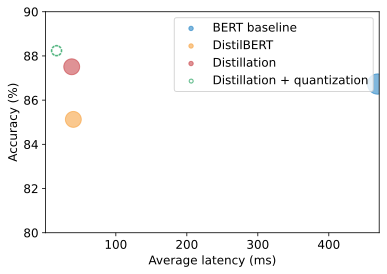

In [56]:
plot_metrics(perf_metrics, optim_type)
'''
아니 이게 말이돼? 속도 정확도 전부 좋은 모델 완성
속도가 말이 안되게 빨라짐

'''

# ONNX와 ONNX 런타임으로 추론 최적화하기  
ONNX 포맷으로 내보내면 이런 연산자를 사용해 신경망을 통과하는 데이터 흐름을 표현하기 위해   
계산 그래프를 만든다. 밑에 BERT의 그림을 보여줌  
여기서 노드는 어떤 입력을 받고 Add나 Squeeze같은 연산을 적용하고 그다음 출력을 다음 노드로 전달한다.  



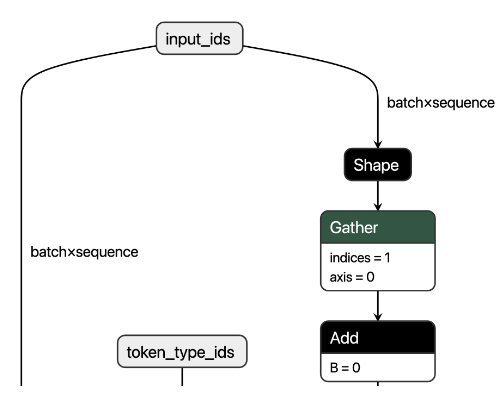

ONNX 표준 연산자와 데이터 타입으로 그래프를 표현하기 때문에  
프레임워크 간 전환을 쉽게 만든다.  
ONNX가 진짜 빛날 때는 ONNX 런타임 또는 짧게 줄여서 ORT 같은 전용 가속기를 함께  
사용할 때이다.(NVIDIA의 TensorRT, 아파치의 TVM)  
ORT는 연산자 융합과 상수 폴딩같은 ONNX 그래프를 최적화하는 도구를 제공한다.  
여러 종류의 하드웨어에서 모델을 실행하도록 실행 공급자를 위한 인터페이스를 제공한다.  

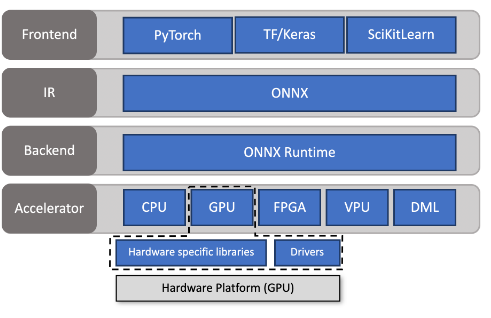

ORT를 실행하기 위해 먼저 정제된 모델을 ONNX 포맷으로 변환한다.  
허깅페이스는 이걸 지원하는 함수가 있다.  
 1. 하나의 파이프라인으로 모델을 초기화한다.
 2. ONNX가 계산 그래프를 기록하도록 플레이스홀더 입력으로 파이프라인 실행  
 (대충 실제 데이터와 똑같은 임의의 데이터 한개 넣어줌)
 3. 동적 시퀀스 길이를 처리하기 위해 동적인 축을 정의한다.
 4. 네트워크 파라미터와 함께 이 그래프를 저장한다.

In [50]:
import os
from psutil import cpu_count

os.environ["OMP_NUM_THREADS"] = f"{cpu_count()}"
os.environ["OMP_WAIT_POLICY"] = "ACTIVE"

In [57]:
from transformers.convert_graph_to_onnx import convert

model_ckpt = "kwkwkwkwpark/distilbert-base-uncased-distilled-clinc"
onnx_model_path = Path("onnx/model.onnx")
convert(framework="pt", model=model_ckpt, tokenizer=tokenizer,
        output=onnx_model_path, opset=12, pipeline_name="text-classification")

/usr/local/lib/python3.10/dist-packages/transformers/convert_graph_to_onnx.py:361: FutureWarning: The `transformers.convert_graph_to_onnx` package is deprecated and will be removed in version 5 of Transformers
  warnings.warn(


ONNX opset version set to: 12
Loading pipeline (model: kwkwkwkwpark/distilbert-base-uncased-distilled-clinc, tokenizer: DistilBertTokenizerFast(name_or_path='kwkwkwkwpark/distilbert-base-uncased-distilled-clinc', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, n

/usr/local/lib/python3.10/dist-packages/transformers/models/distilbert/modeling_distilbert.py:231: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  mask, torch.tensor(torch.finfo(scores.dtype).min)


In [58]:
from onnxruntime import (GraphOptimizationLevel, InferenceSession,
                         SessionOptions)

def create_model_for_provider(model_path, provider="CPUExecutionProvider"):
    options = SessionOptions()
    options.intra_op_num_threads = 1
    options.graph_optimization_level = GraphOptimizationLevel.ORT_ENABLE_ALL
    session = InferenceSession(str(model_path), options, providers=[provider])
    session.disable_fallback()
    return session #onnx를 받아서 모델을 만드는 과정

In [59]:
onnx_model = create_model_for_provider(onnx_model_path)

In [60]:
inputs = clinc_enc["test"][:1]
del inputs["labels"]
logits_onnx = onnx_model.run(None, inputs)[0]
logits_onnx.shape
'''
onnxruntime.InferenceSession.run(output_names, input_feed)에서 output_names에 None을 사용하면 모델의 모든 출력 텐서를 반환합니다.
이는 모델의 모든 출력을 수동으로 지정하지 않아도 되기 때문에 코드가 더 간단해지고 편리합니다.
'''

(1, 151)

In [61]:
np.argmax(logits_onnx)

61

In [62]:
clinc_enc["test"][0]["labels"]

61

In [63]:
from scipy.special import softmax

class OnnxPipeline:
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer

    def __call__(self, query):
        model_inputs = self.tokenizer(query, return_tensors="pt")
        inputs_onnx = {k: v.cpu().detach().numpy()
                       for k, v in model_inputs.items()}
        logits = self.model.run(None, inputs_onnx)[0][0, :]
        probs = softmax(logits)
        pred_idx = np.argmax(probs).item()
        return [{"label": intents.int2str(pred_idx), "score": probs[pred_idx]}]

In [64]:
pipe = OnnxPipeline(onnx_model, tokenizer)
pipe(query)

[{'label': 'car_rental', 'score': 0.7640181}]

In [65]:
class OnnxPerformanceBenchmark(PerformanceBenchmark):
    def __init__(self, *args, model_path, **kwargs):
        super().__init__(*args, **kwargs)
        self.model_path = model_path

    def compute_size(self):
        size_mb = Path(self.model_path).stat().st_size / (1024 * 1024)
        print(f"모델 크기 (MB) - {size_mb:.2f}")
        return {"size_mb": size_mb}

In [66]:
optim_type = "Distillation + ORT"
pb = OnnxPerformanceBenchmark(pipe, clinc["test"], optim_type,
                              model_path="onnx/model.onnx")
perf_metrics.update(pb.run_benchmark())

모델 크기 (MB) - 255.98
평균 레이턴시 (ms) - 26.05 +\- 4.53
테스트 세트 정확도 - 0.875


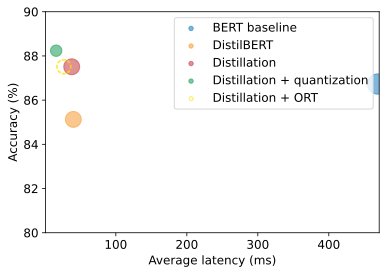

In [67]:
plot_metrics(perf_metrics, optim_type)

In [68]:
from onnxruntime.quantization import quantize_dynamic, QuantType

model_input = "onnx/model.onnx"
model_output = "onnx/model.quant.onnx"
quantize_dynamic(model_input, model_output, weight_type=QuantType.QInt8)

'''
onnx 모델을 양자화 하는 방법 크게 3가지 지원 정적,동적,양자화
양자화할 모델, 저장할 모델, 양자화할 타입을 인자로 사용
'''

'\nonnx 모델을 양자화 하는 방법 크게 3가지 지원 정적,동적,양자화\n양자화할 모델, 저장할 모델, 양자화할 타입을 인자로 사용\n'

In [69]:
onnx_quantized_model = create_model_for_provider(model_output)
pipe = OnnxPipeline(onnx_quantized_model, tokenizer)
optim_type = "Distillation + ORT (quantized)"
pb = OnnxPerformanceBenchmark(pipe, clinc["test"], optim_type,
                              model_path=model_output)
perf_metrics.update(pb.run_benchmark())

모델 크기 (MB) - 64.36
평균 레이턴시 (ms) - 15.32 +\- 3.63
테스트 세트 정확도 - 0.880


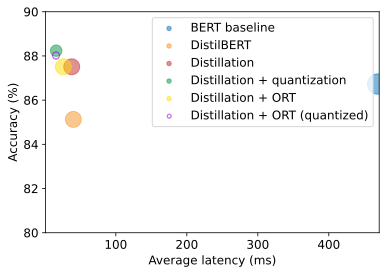

In [70]:
plot_metrics(perf_metrics, optim_type)
'''
아마 더 좋은데 그 BERT 모델이 너무 커서 제대로 표현 안되는
''

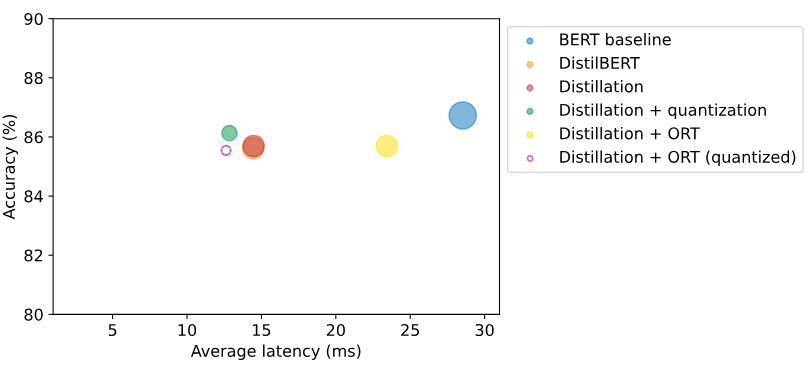

같은 양자화 인데 레이턴시가 30% 더 줄은 이유는  
파이토치에서는 nn.linear만 양자화 했는데 onnx에서 양자화는 임베딩 층도 양자화 해버림  

# 가중치 가중치기  
메모리 사용이 극단적으로 제한되는 상황에서 최대한 메모리 사용을 줄이기 위해  
제일 쓸모없는 가중치를 지워버리면서 파라미터 줄이기

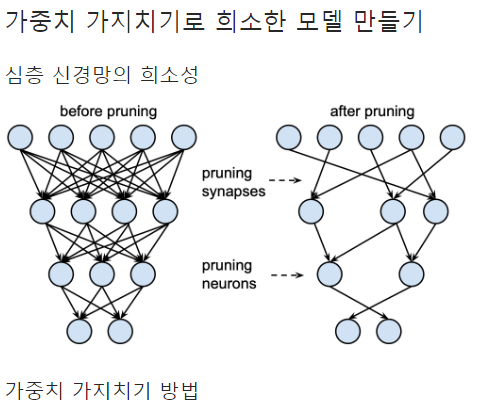

가지치기의 기본 개념은 훈렪나느 동안 가중치 연결을 점진적으로 제거해  
모델을 희소하게 만드는 것이다. 양자화와 같이 사용하면 추가 압축 가능  

##가중치 가지치기 방법  
중요도 점수 행렬 S를 계산하고 중요도 순으로 최상위 K%의 가중치를 선택한다.  
$Top_k(S)_{ij}=\begin{cases} 1 & S_{ij}\text{가 최상위 k%일 경우} \\
0 & \text{그 외의 경우}
\end{cases}$  
사실상 k는 모델의 희소성 양, 즉 값이 0인 가중치 비율을 제어하는 새로운 변수 역할을 한다.  
k값이 낮을수록 행렬은 더 희소해진다.  
이 점수를 사용해 마스크 행렬 M 을 만든다. 이 행렬은 정방향 패스에서 입력 $x_i$에  
곱해지는 가중치 $W_{ij}$를 마스킹해 희소한 활성화 $a_i$를 만든다.  
$a_i=\Sigma_jW_{ij}M_{ij}x_j$  
***  
가지치기 방법은 중요 질문을 고려해야 한다.  
 1. 어떤 가중치를 삭제해야 하나요?  
 2. 최상의 성능을 내려면 남은 가중치를 어떻게 조정해야 하나요?  
 3. 이런 가지치기 계산을 효율적으로 수행하는 방법은 뭘까요?  

점수 행렬 S를 계산하는 방법은 위의 경우를 전부 고려해야한다.  
초창기 가지치기 방법의 하나이자 가장 인기 있는 절대값 가지치기를 설명한다.  

***  
##절대값 가지치기  
가중치 절대값 크기에 따라 $S=(|W_{ij}|)_{1≤j,j≤n}$을 계산한다.  
보통 어떤 가중치가 중요한지 학습하도록 모델을 훈련하고 가장 덜 중요한  
가중치를 가지치기하는 식으로 반복적으로 절대값 가지치기를 적용하는 경우가 일반적이다.  
문제는 계산량이 많다. 가지치기 매 단계마다 모델을 훈련해 수렴시켜야한다.  
그래서 희소성 초깃값 $s_i$를 일정 단계 N 후에 최종 값으로 점짐적으로 증가하는게 낫다.  
$s_t=s_f+(s_i-s_f)(1-\frac{t-t_o}{N△t})^3$  
$t∈[t_o,t_o+△t,…,t_o+N△t]$  
이 가지치기 개념은 매 t스텝마다 이진 마스트 M을 업데이트해 훈련하는 동안 마스킹된  
가중치를 다시 활성화하고 가지치기로 인해 발생할지 모를 잠재적인 정확도 손실을  
복구하는 것입니다.  
세제곱 항은 가중치 가지치기의 속도가 초기 단계에 가장 높고 그후 점차 감소한다.


In [ ]:
# 가지치기에 사용되는 세제곱 희소성 스케줄러
import numpy as np
import matplotlib.pyplot as plt

def _sparsity(t, t_0=0, dt=1, s_i=0, s_f=0.9, N=100):
    return s_f + (s_i - s_f) * (1 - (t - t_0) / (N * dt))**3

steps = np.linspace(0,100,100)
values = [_sparsity(t) for t in steps]

fig, ax = plt.subplots()
ax.plot(steps, values)
ax.set_ylim(0,1)
ax.set_xlim(0,100)
ax.set_xlabel("Pruning step")
ax.set_ylabel("Sparsity")
plt.grid(linestyle="dashed")
plt.show()

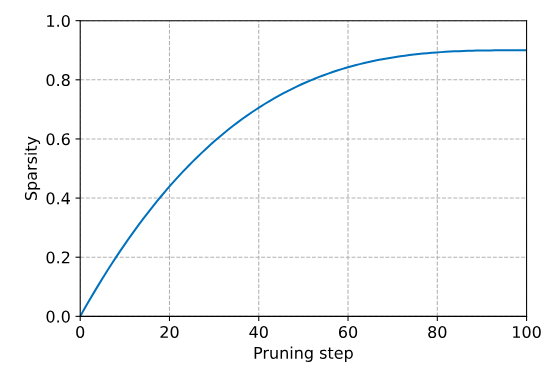

문제는 절대값 가지치기는 각 가중치의 중요도가 현재 작업과 직접적으로 관련된 순수한  
지도 학습을 위해 고안됐다는 문제가 있다.  
이와 달리 전이 학습에서는 가중치의 중요도가 주로 사전 룬현 단계에서 결정된다.  
절대값 가지치기로 인해 미세 튜닝 작업에서 중요한 가중치가 삭제될 수도 있다.  
따라서 최근 허깅페이스 연구자들은 이동 가지치기라는 적응적 방식을 제안했다.  
## 이동 가지치기  
기본 개념은 미세 튜닝하는 동안 점진적으로 가중치를 제거해 모델을 점차 희소하게 만드는 것이다.  
새로운 점은 미세 튜닝하는 동안 가중치와 점수가 모두 학습된다.  
따라서 점수를 가중치에서 바로 구하지 않고 임의적이며 신경망의 다른 파라미터처럼 경사 하강법을 통해 학습한다.  
개념에 의하면, 직관적으로 원점으로부터 가장 크게 이동하는 가중치가 가장 중요하다.  
가중치가 원점에서 멀어질수록 점수가 증가한다.  
왼쪽이 절대 오른쪽이 이동  
절대값 가지치기의 경우 사전 훈련된가중치 값이 미세 튜닝의 가치치기에 큰 영향을 미치지만  
이동 가지치기는 전영역에서 고르게 가지치기가 된다.

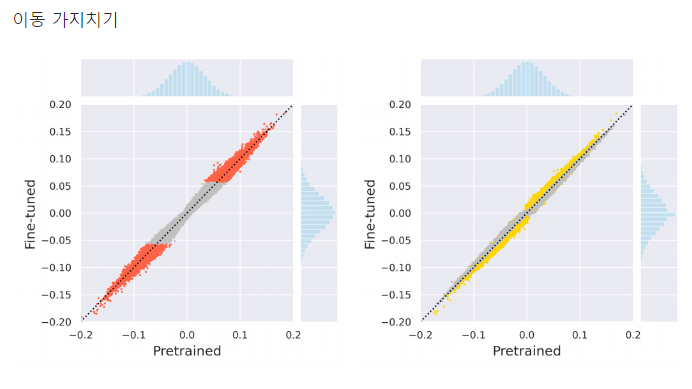

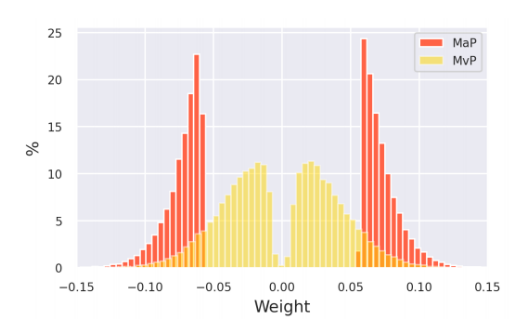